In [3]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "kesimeg/function-calling-llama-3.1-8B",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd

In [5]:
function_df = pd.read_csv("out.csv")
alpaca_df = pd.read_csv("out_alpaca.csv")
en_dataset = load_dataset('json', data_files={"Salesforce/xlam-function-calling-60k"}, split = "train")
en_dataset = en_dataset.remove_columns(["id"])

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
NUM_SAMPLES_TOTAL = 10000 #tr_dataset.num_rows
NUM_SAMPLES_TRAIN = int(NUM_SAMPLES_TOTAL * 0.9)
NUM_SAMPLES_INSTRUCT = int(NUM_SAMPLES_TRAIN * 0.3)

In [7]:
function_indices = function_df["2"].nlargest(NUM_SAMPLES_TOTAL).index
insruction_indices = alpaca_df["2"].nlargest(NUM_SAMPLES_INSTRUCT).index
function_calling_dataset = en_dataset.select(function_indices)
function_calling_dataset = function_calling_dataset.shuffle(seed=42)
function_calling_train = function_calling_dataset.select(range(NUM_SAMPLES_TRAIN))
function_calling_validation = function_calling_dataset.select(range(NUM_SAMPLES_TRAIN, NUM_SAMPLES_TOTAL)) #validation is only function calling

In [8]:
from unsloth.chat_templates import get_chat_template
import json
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    query = examples["query"]
    answer = examples["answers"]
    convos = [{"role":"user","content":query}]
    tool_object = json.loads(examples["tools"])
    texts = tokenizer.apply_chat_template(convos,tools=tool_object,tokenize = False, add_generation_prompt = False)
    texts = texts.replace('"parameters": d','"arguments": d') # original tool use function uses parameters our dataset uses arguments

    return { "text" : texts, }
pass

function_calling_train= function_calling_train.map(formatting_prompts_func, batched = False,)
function_calling_validation = function_calling_validation.map(formatting_prompts_func, batched = False,)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
def formatting_instruction_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    if inputs:
        convos = [{"role":"user","content":instructions + " " + inputs}]
    else:
        convos = [{"role":"user","content":instructions},{"role":"assistant","content":outputs}]

    texts = tokenizer.apply_chat_template(convos,tokenize = False, add_generation_prompt = False)
    return { "text" : texts, }
pass


dataset_instruction = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset_instruction = dataset_instruction.map(formatting_instruction_prompts_func, batched = False,)

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

In [10]:
dataset_instruction = dataset_instruction.select(insruction_indices)
dataset_instruction = dataset_instruction.shuffle(seed=42)

In [11]:
NUM_SAMPLES_INSTRUCT_TRAIN = int(NUM_SAMPLES_INSTRUCT * 0.9)

instruction_train = dataset_instruction.select(range(NUM_SAMPLES_INSTRUCT_TRAIN))
instruction_validation = dataset_instruction.select(range(NUM_SAMPLES_INSTRUCT_TRAIN, NUM_SAMPLES_INSTRUCT))

In [12]:
train_dataset = concatenate_datasets([function_calling_train, instruction_train])
validation_set = concatenate_datasets([function_calling_validation, instruction_validation])

In [13]:
def calculate_function_similarity(ground_truth_args,section_score,input_data,truth_item,index):

    num_args = max(len(ground_truth_args),1)
    key_score = section_score/num_args
    score = 0

    if not ground_truth_args and not input_data[index]["arguments"]: # if no arguments are called accept it as correct
        return key_score

    for argument in ground_truth_args:

        try:
            arg_val = input_data[index]["arguments"][argument]
            if arg_val == truth_item["arguments"][argument]:
                score += key_score
            else:
                score += key_score/2 #partial points for arguments that are called with wrong value
        except Exception as e:
            #print("Exception",e)
            pass

    return score

In [14]:
def calculate_similarity(input_data, ground_truth_data):
    """Calculate a similarity score between two JSON objects based on exact argument matches."""
    score = 0

    # Count the number of sections with "name" in ground truth
    try:
        input_data_names = np.array([item["name"] for item in input_data])
    except:
        return 0
    section_score = 1/len(ground_truth_data)
    for truth_item in ground_truth_data:
        truth_name = truth_item.get('name')
        truth_args = truth_item.get('arguments', {})
        matching_functions = truth_name == input_data_names #check the functions with the same names
        max_matching_score = 0
        for index,match in enumerate(matching_functions):
            max_matching_score = max(calculate_function_similarity(truth_args,section_score,input_data,truth_item,index),max_matching_score)
        score += max_matching_score

    # Sometimes due to precision there can be cases such as score is 0.9999, we automatically convert to 1
    if score >= 0.99:
        score = 1
    return score

In [15]:
import json
def compare_json_strings(input_json_str, ground_truth_json_str):
    try:
        input_data = json.loads(input_json_str)
        ground_truth_data = json.loads(ground_truth_json_str)
        return calculate_similarity(input_data, ground_truth_data)
    except json.JSONDecodeError:
        #print("Invalid JSON format.")
        return 0

In [17]:
import torch
torch.cuda.empty_cache()

In [94]:
def extract_between_last_two_eot_ids(text):
    # Find all occurrences of <|eot_id|> in the text
    text = text.replace('<|start_header_id|>assistant<|end_header_id|>', '')
    text = text.replace('<|start_header_id|>', '')
    text = text.replace('assistant: ', '')
    eot_ids = [match.start() for match in re.finditer(r'<\|eot_id\|>', text)]

    # Check if there are at least two occurrences
    try:
        # Get the positions of the last two occurrences of <|eot_id|>
        start_pos = eot_ids[1] + len('<|eot_id|>')  # After the second-to-last <|eot_id|>
        end_pos = eot_ids[2]  # At the last <|eot_id|>

        # Extract the text between the last two <|eot_id|> occurrences
        return text[start_pos:end_pos]
    except:
        print("EXCEPTİON")
        return None

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pprint
FastLanguageModel.for_inference(model)
eval_dataloader = DataLoader(function_calling_validation, batch_size=16, shuffle=False)

score_list = []

import time
import re

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Move batch to the correct device (GPU or CPU)
            tokenizer.padding_side = "left"
            inputs = tokenizer(
                batch["text"],
            return_tensors = "pt",padding="longest").to("cuda")
            #print(tokenizer.batch_decode(inputs["input_ids"]))

            outputs = model.generate(**inputs, max_new_tokens = 512)

            preds = tokenizer.batch_decode(outputs)
            for i in range(len(preds)):
              try:
                pred = preds[i]
                pred = extract_between_last_two_eot_ids(pred)
                score = compare_json_strings(pred,batch["answers"][i])
              except:
                score = 0
              score_list.append(score)

    return score_list


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

score_list = evaluate(model, eval_dataloader)

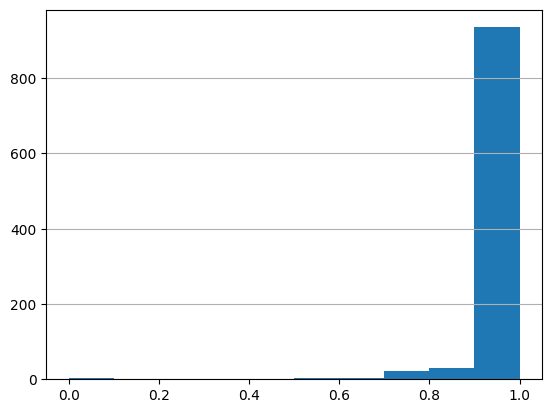

In [123]:
plt.hist(score_list)
plt.grid(axis="y")